In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ofdm import *
from mod import *
from fading import *
from gauss import *
from estimate import *
from equalize import *
from simulate import *
import random
from simulate_10000 import *

# 1 Mô Phỏng

In [2]:
x_time = 14 # 0-13
y_freq = 3276 # 0-3275
snr = 20
mod_type ="16QAM"


if mod_type == "QPSK":
    z_mod = 2
elif mod_type == "16QAM":
    z_mod = 4
elif mod_type == "64QAM":
    z_mod = 6
else:
    print("Modulation type not supported")
    exit(1)

# đọc dữ liệu từ file Excel
df = pd.read_excel('data/l1_mini_project_ce_eq_dmrs_data.xlsx', sheet_name='Sheet1', header=None)
arr_r = df[0].apply(lambda x: complex(str(x).replace('i', 'j').replace(' ', ''))).to_numpy()

Tạo chuỗi bit ngẫu nhiêu (giá trị 0 và 1) có kích thước 3276 × 13 × (z)

In [3]:
bits = ''.join(str(random.randint(0, 1)) for _ in range((x_time-1)*y_freq*z_mod))


Điều chế  -> 3276x13 ký hiệu

In [4]:
#symbols_16qam  = bits_to_symbols_16QAM(bits)
symbol_mod = modulation(bits, mod_type)

Ánh xạ vào lưới tài nguyên :trên xuống dưới, trừ trái sang phải:

In [5]:
grid = np.zeros((y_freq, x_time), dtype=complex)

for i in range(y_freq):
    for j in range(x_time):
        if j < 3:
            grid[i, j] = symbol_mod[j*y_freq + i]
        elif j==3:
            grid[i, j] = arr_r[i]
        else:
            grid[i, j] = symbol_mod[(j-1)*y_freq + i]

Từ grid -> ánh xạ sang OFDM

In [6]:
# ofdm cần thêm CP -> tín hiệu miền thời gian 61440 mẫu -> mà mới có 3276 * 14 = 61376 -> padding thêm

ofdm = np.zeros((4384, x_time), dtype=complex)
for i in range(x_time):
    ofdm[:, i] = ofdm_single_symbol(grid[:, i], 4096, 288)
    
# Ghép tất cả OFDM symbol thành 1 chuỗi dài 61376 mẫu
ofdm_signal = ofdm.flatten(order='F')  # flatten theo cột (trước sau)
# Padding thêm 64 mẫu 0 để đủ 61440 mẫu
padding = np.zeros(64, dtype=complex)
ofdm_signal = np.concatenate((ofdm_signal, padding))


Cho tín hiệu OFDM qua Fading channel  TDLB100-25

TDL: Tapped Delay Line – mô hình kênh đa đường có nhiều taps
B: Profile B (mức phản xạ trung bình)
100ns: Delay spread
25Hz: Doppler shift (UE di chuyển, tốc độ ~3km/h)

In [7]:
fs = 30.72e6  # sampling rate (Hz) cho 5G LTE BW = 20MHz (chuẩn)
channel_h = generate_tdlb_channel(fs)
faded_signal = apply_fading_channel(ofdm_signal, channel_h)
#faded_signal = ofdm_signal

Tiếp tục cho tín hiệu đi qua nhiễu Gauss có SNR 20dB


In [8]:
rx_signal = add_awgn(faded_signal, snr_db=snr)

Giải điều chế OFDM

In [9]:
#rx_grid = ofdm_demodulate(rx_signal, fft_size=4096, cp_len=288, num_symbols=14)
rx_grid = ofdm_demodulate(rx_signal, fft_size=4096, cp_len=288, num_symbols=14)

# Cắt lại phần tương ứng với 3276 subcarriers (đầu tiên)
rx_grid = rx_grid[:3276, :]  # Kích thước (3276 x 14)

Giải điều chế 16QAM hardbit

In [10]:
data_cols = [i for i in range(14) if i != 3]  # loại bỏ cột 3 (DMRS)
rx_bits_all = []

for col in data_cols:
    rx_symbols = rx_grid[:, col]
    bits_col = demodulation(rx_symbols, mod_type)
    rx_bits_all.extend(bits_col)

print("Tổng số bit sau giải điều chế:", len(rx_bits_all))  # sẽ là 3276 * 13 * 4 = 170352


Tổng số bit sau giải điều chế: 170352


So sánh sai lệch dữ dữ liệu 16QAM giữa TX & RX theo MSE

In [11]:

bits_rx = np.array([int(b) for b in bits], dtype=int)
bits_tx = np.array([int(b) for b in rx_bits_all], dtype=int)

#mse_bits = np.mean((bits_rx - bits_tx) ** 2)
mse_symbol_full = np.mean(np.abs(rx_grid - grid) ** 2)
print("MSE giữa bit TX và RX:", mse_symbol_full)

MSE giữa bit TX và RX: 2.258754826942932


So sánh và tính toán sai lệch bit (BER) giữa đầu phát và đầu thu.

In [12]:
ber = np.mean(bits_tx != bits_rx)
print("BER:", ber)

BER: 0.44796069315300086


# 2 ƯỚC LƯỢNG

Uớc lượng kênh truyền bằng thuật toán LS. 


In [13]:
#https://tailieusinhvien.net/phan-tich-so-sanh-ky-thuat-uoc-luong-kenh-ls-va-mmse-trong-he-thong-ofdm-duoi-nuoc-7436/
df = pd.read_excel('data/l1_mini_project_ce_eq_dmrs_data.xlsx', sheet_name='Sheet1', header=None)
X = df[0].apply(lambda x: complex(str(x).replace('i', 'j').replace(' ', ''))).to_numpy()

Y = rx_grid[:, 3]  # cột DMRS

# X= H.x +n -> tìm H sao cho ||Y-Hx||^2 min; H = X^-1 .Y
h_ls = estimate_channel_ls(X, Y)

Cân bằng kênh truyền bằng thuật toán ZF. 


In [14]:
rx_grid_equalized = equalize_zf(rx_grid, h_ls)
# Giải điều chế 16-QAM và tính BER/MSE
rx_bits_all_zf = []
data_cols = [i for i in range(14) if i != 3]
for col in data_cols:
    rx_symbols = rx_grid_equalized[:, col]
    bits_col = demodulation(rx_symbols, mod_type)
    rx_bits_all_zf.extend(bits_col)

bits_rx = np.array([int(b) for b in bits], dtype=int)
bits_tx_zf = np.array([int(b) for b in rx_bits_all_zf], dtype=int)
mse_zf = np.mean(np.abs(rx_grid_equalized - grid) ** 2)
ber_zf = np.mean(bits_rx != bits_tx_zf)

print(f"MSE (ZF): {mse_zf:.6f}")
print(f"BER (ZF): {ber_zf:.6f}")

MSE (ZF): 0.359597
BER (ZF): 0.016219


Thay đổi giá trị SNR từ 0 đến 30, khoảng cách 2dB. Vẽ biểu đồ MSE và biểu đồ BER.


SNR = 0 dB → BER = 0.32610, MSE = 4.73807
SNR = 2 dB → BER = 0.28590, MSE = 5.19825
SNR = 4 dB → BER = 0.24137, MSE = 3.62186
SNR = 6 dB → BER = 0.19360, MSE = 1.23553
SNR = 8 dB → BER = 0.15354, MSE = 1.54508
SNR = 10 dB → BER = 0.11421, MSE = 0.76107
SNR = 12 dB → BER = 0.08120, MSE = 0.90748
SNR = 14 dB → BER = 0.05630, MSE = 0.26113
SNR = 16 dB → BER = 0.03816, MSE = 0.12881
SNR = 18 dB → BER = 0.02503, MSE = 0.09354
SNR = 20 dB → BER = 0.01523, MSE = 0.04544
SNR = 22 dB → BER = 0.00925, MSE = 0.08146
SNR = 24 dB → BER = 0.00561, MSE = 0.02937
SNR = 26 dB → BER = 0.00295, MSE = 0.01232
SNR = 28 dB → BER = 0.00185, MSE = 0.01724
SNR = 30 dB → BER = 0.00109, MSE = 0.00537


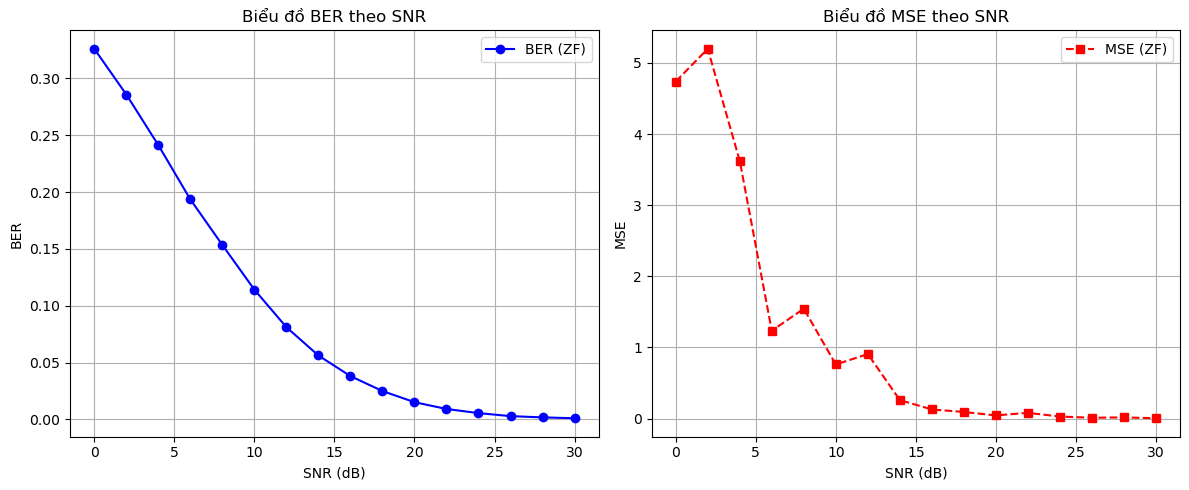

In [15]:
equalizer_mode ="ZF"
snr_range_db, ber_results, mse_results = simulate(faded_signal, X, bits, grid, equalizer_mode, mod_type)
    
    
plt.figure(figsize=(12, 5))
# BER
plt.subplot(1, 2, 1)
plt.plot(snr_range_db, ber_results, 'bo-', label=f'BER ({equalizer_mode})')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('Biểu đồ BER theo SNR')
plt.grid(True)
plt.legend()

# MSE
plt.subplot(1, 2, 2)
plt.plot(snr_range_db, mse_results, 'rs--', label=f'MSE ({equalizer_mode})')
plt.xlabel('SNR (dB)')
plt.ylabel('MSE')
plt.title('Biểu đồ MSE theo SNR')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



So sánh MSE và BLER giữa có và không có sử dụng ước lượng/cân bằng kênh truyền. 


# 3 Phát triển và đánh giá thuật toán ước lượng kênh truyền nâng cao.

Thay thế thuật toán LS bằng thuật toán ước lượng kênh truyền nâng cao MMSE, sử 
dụng bộ cân bằng MMSE và 

In [16]:
h_mmse = estimate_channel_mmse(X, Y, snr_db=snr)  # SNR = 20 dB

# Áp dụng cân bằng MMSE thay vì ZF
snr_db = snr  # Giả định SNR = 20 dB như trong notebook
rx_grid_equalized = np.zeros_like(rx_grid, dtype=complex)
rx_grid_equalized = equalize_mmse(rx_grid, h_mmse, snr_db)
# Giải điều chế 16-QAM và tính BER/MSE
rx_bits_all_mmse = []
data_cols = [i for i in range(14) if i != 3]
for col in data_cols:
    rx_symbols = rx_grid_equalized[:, col]
    bits_col = demodulation(rx_symbols, mod_type)
    rx_bits_all_mmse.extend(bits_col)

bits_rx = np.array([int(b) for b in bits], dtype=int)
bits_tx_mmse = np.array([int(b) for b in rx_bits_all_mmse], dtype=int)
mse_mmse = mse_zf = np.mean(np.abs(rx_grid_equalized - grid) ** 2)
ber_mmse = np.mean(bits_rx != bits_tx_mmse)

print(f"MSE (MMSE): {mse_mmse:.6f}") # tính theo ký hiệu phức
print(f"BER (MMSE): {ber_mmse:.6f}") # tính theo bit


MSE (MMSE): 0.035777
BER (MMSE): 0.016994


so sánh biểu đồ MSE, BER với thuật toán LS/ZF.

SNR = 0 dB → BER = 0.34507, MSE = 0.62132
SNR = 2 dB → BER = 0.29363, MSE = 0.51602
SNR = 4 dB → BER = 0.24274, MSE = 0.41965
SNR = 6 dB → BER = 0.19976, MSE = 0.33849
SNR = 8 dB → BER = 0.15520, MSE = 0.25811
SNR = 10 dB → BER = 0.11588, MSE = 0.19198
SNR = 12 dB → BER = 0.08405, MSE = 0.14255
SNR = 14 dB → BER = 0.05790, MSE = 0.10195
SNR = 16 dB → BER = 0.03932, MSE = 0.07302
SNR = 18 dB → BER = 0.02542, MSE = 0.04971
SNR = 20 dB → BER = 0.01591, MSE = 0.03449
SNR = 22 dB → BER = 0.01004, MSE = 0.02367
SNR = 24 dB → BER = 0.00557, MSE = 0.01589
SNR = 26 dB → BER = 0.00337, MSE = 0.01049
SNR = 28 dB → BER = 0.00204, MSE = 0.00713
SNR = 30 dB → BER = 0.00106, MSE = 0.00454


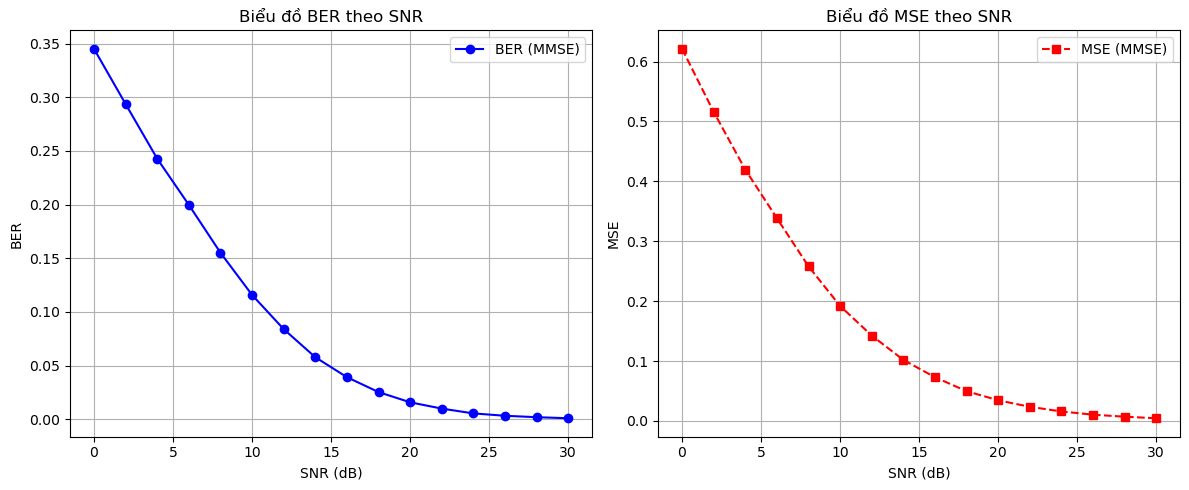

In [17]:
equalizer_mode = 'MMSE'
snr_range_db, ber_results_mmse, mse_results_mmse = simulate(faded_signal, X, bits, grid, equalizer_mode, mod_type)

plt.figure(figsize=(12, 5))
# BER
plt.subplot(1, 2, 1)
plt.plot(snr_range_db, ber_results_mmse, 'bo-', label=f'BER ({equalizer_mode})')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('Biểu đồ BER theo SNR')
plt.grid(True)
plt.legend()

# MSE
plt.subplot(1, 2, 2)
plt.plot(snr_range_db, mse_results_mmse, 'rs--', label=f'MSE ({equalizer_mode})')
plt.xlabel('SNR (dB)')
plt.ylabel('MSE')
plt.title('Biểu đồ MSE theo SNR')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



Thực hiện đánh giá lại các phương pháp với số lượng mẫu là 10000 lưới tài nguyên, 
bổ sung thêm các kiểu điều chế QPSK và 64QAM.

Loop 1/4 | SNR = 0 dB → BER = 0.34065, MSE = 0.60284
Loop 1/4 | SNR = 2 dB → BER = 0.28696, MSE = 0.48796
Loop 1/4 | SNR = 4 dB → BER = 0.23412, MSE = 0.38289
Loop 1/4 | SNR = 6 dB → BER = 0.18585, MSE = 0.29587
Loop 1/4 | SNR = 8 dB → BER = 0.14060, MSE = 0.22155
Loop 1/4 | SNR = 10 dB → BER = 0.09878, MSE = 0.15921
Loop 1/4 | SNR = 12 dB → BER = 0.06761, MSE = 0.11721
Loop 1/4 | SNR = 14 dB → BER = 0.04241, MSE = 0.07963
Loop 1/4 | SNR = 16 dB → BER = 0.02607, MSE = 0.05401
Loop 1/4 | SNR = 18 dB → BER = 0.01610, MSE = 0.03798
Loop 1/4 | SNR = 20 dB → BER = 0.00945, MSE = 0.02483
Loop 1/4 | SNR = 22 dB → BER = 0.00574, MSE = 0.01705
Loop 1/4 | SNR = 24 dB → BER = 0.00275, MSE = 0.01047
Loop 1/4 | SNR = 26 dB → BER = 0.00190, MSE = 0.00736
Loop 1/4 | SNR = 28 dB → BER = 0.00073, MSE = 0.00443
Loop 1/4 | SNR = 30 dB → BER = 0.00038, MSE = 0.00292
Loop 2/4 | SNR = 0 dB → BER = 0.34723, MSE = 0.62869
Loop 2/4 | SNR = 2 dB → BER = 0.30269, MSE = 0.53858
Loop 2/4 | SNR = 4 dB → BER = 0.256

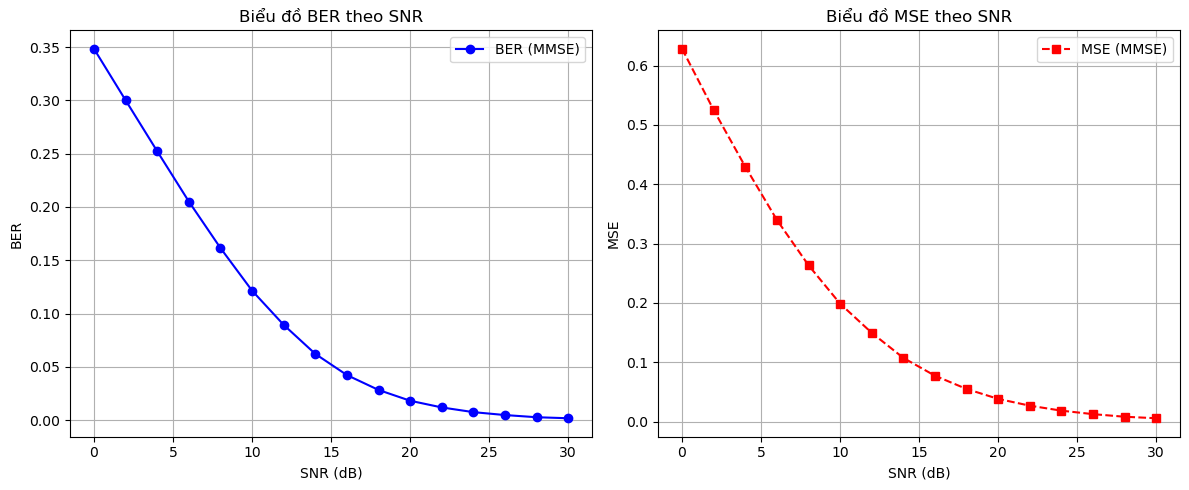

ber_results_mmse_10k: [0.34833022212829906, 0.30005371231332767, 0.25223214285714285, 0.2050797759932375, 0.16147594392786702, 0.12146614069690992, 0.0893649619611158, 0.06212577486615948, 0.042268361979900436, 0.02831636846059923, 0.018187341504649197, 0.011910632102939796, 0.007494775523621678, 0.004766600920447074, 0.00272083685545224, 0.001763994552456091]
mse_results_mmse_10k: [0.6281343108878497, 0.5249266634432002, 0.4295441532880944, 0.33979128334594355, 0.26338882041157613, 0.19863344758942814, 0.14950218832919993, 0.1072833838949003, 0.07725937391643706, 0.0549295046384113, 0.03821042785471587, 0.026784369102353132, 0.018391012703923064, 0.012530793106338048, 0.008155811521709418, 0.005611791887201727]
avg ber at 20dB: 0.018187341504649197
avg mse at 20dB: 0.03821042785471587


In [18]:
equalizer_mode = 'MMSE'
mod_type = '16QAM'  # Hoặc QPSK, 16QAM
snr_range_db_10k, ber_results_mmse_10k, mse_results_mmse_10k = simulate_10000(4, equalizer_mode,mod_type, X )

plt.figure(figsize=(12, 5))
# BER
plt.subplot(1, 2, 1)
plt.plot(snr_range_db_10k, ber_results_mmse_10k, 'bo-', label=f'BER ({equalizer_mode})')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('Biểu đồ BER theo SNR')
plt.grid(True)
plt.legend()

# MSE
plt.subplot(1, 2, 2)
plt.plot(snr_range_db_10k, mse_results_mmse_10k, 'rs--', label=f'MSE ({equalizer_mode})')
plt.xlabel('SNR (dB)')
plt.ylabel('MSE')
plt.title('Biểu đồ MSE theo SNR')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

print("ber_results_mmse_10k:", ber_results_mmse_10k)
print("mse_results_mmse_10k:", mse_results_mmse_10k)

print("avg ber at 20dB:", ber_results_mmse_10k[10])  # 20dB là chỉ số thứ 2 trong mảng
print("avg mse at 20dB:", mse_results_mmse_10k[10])  # 20dB là chỉ số thứ 2 trong mảng